# Mammogram mass: benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:

   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Goal

The goal is to find the ML method that achieves the highest accuracy in predicting whether a mass is benign or malignant.

To achieve this, a few steps were followed:
1. Exploratory Data Analysis
2. Data Pre-processing
3. Apply different supervised machine learning methods

The methods include:
* Decision Tree
* Random Forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* Neural Network

## Import libraries and load data

In [1]:
%pip install pydotplus
%pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns           
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline



from IPython.display import Image  
from six import StringIO  
import pydotplus

In [11]:
masses_data = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


## 1. Exploratory Data Analysis (EDA)


### 1.1 High-level Description

The `masses_data` dataset comprises 961 entries and 6 columns. While the dataset contains 961 entries, not all columns are fully populated:

- **BI-RADS**: 959 non-null entries
- **age**: 956 non-null entries
- **shape**: 930 non-null entries
- **margin**: 913 non-null entries
- **density**: 885 non-null entries 

The target variable, `severity`, however, is complete with 961 entries.

Statistical insights reveal that the average age of patients in the dataset is approximately 55.5 years. For categorical variables such as `shape`, `margin`, `density`, and `BI-RADS`, the mode provides more meaningful insights:

- **BI-RADS**: Mode = 4.0
- **shape**: Mode = 4.0
- **margin**: Mode = 1.0
- **density**: Mode = 3.0

From the data, the mean of the `severity` column is approximately 0.463, highlighting that the dataset is fairly balanced in terms of benign (0) and malignant (1) classifications.

From a datatype perspective, five columns hold `float64` type data while `severity` (target) contains `int64` values. This dataset presents a mix of continuous and categorical data, with certain missing entries that might require preprocessing before analysis or modeling.


In [12]:
masses_data.shape

(961, 6)

In [13]:
masses_data.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [14]:
masses_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   959 non-null    float64
 1   age       956 non-null    float64
 2   shape     930 non-null    float64
 3   margin    913 non-null    float64
 4   density   885 non-null    float64
 5   severity  961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


In [15]:
masses_data.dtypes

BI-RADS     float64
age         float64
shape       float64
margin      float64
density     float64
severity      int64
dtype: object

In [16]:
# Get the mode for each variable
masses_data.mode().iloc[0]

BI-RADS      4.0
age         59.0
shape        4.0
margin       1.0
density      3.0
severity     0.0
Name: 0, dtype: float64

### 1.2 Drop irrelevant columns
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.


In [17]:
masses_data = masses_data.drop(['BI-RADS'], axis=1)
masses_data.head(5)

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
1,43.0,1.0,1.0,NaN,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
4,74.0,1.0,5.0,NaN,1


### 1.3 Missing Values

The dataset has missing values in several columns, most notably in density (7.9%), followed by margin, shape, and age. There are no missing values in the severity column. We identified 130 rows with at least one missing value, some of which had more than one missing attribute. Prior to handling these, the severity distribution was 53.69% benign (0) and 46.31% malignant (1). After deciding to eliminate these rows, we were left with 831 records. Importantly, this action improved the balance of the dataset to 51.50% benign and 48.50% malignant.

In [18]:
# Number of MV per feature
masses_data.isnull().sum()

age          5
shape       31
margin      48
density     76
severity     0
dtype: int64

In [19]:
# Percentage of MV per feature
(masses_data.isnull().sum()/(len(masses_data)))*100

age         0.520291
shape       3.225806
margin      4.994797
density     7.908429
severity    0.000000
dtype: float64

In [20]:
# Check the rows with a least one missing value
masses_data[masses_data.isnull().any(axis=1)]

,age,shape,margin,density,severity
1,43.0,1.0,1.0,NaN,1
4,74.0,1.0,5.0,NaN,1
5,65.0,1.0,NaN,3.0,0
6,70.0,NaN,NaN,3.0,0
7,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...
778,60.0,NaN,4.0,3.0,0
819,35.0,3.0,NaN,2.0,0
824,40.0,NaN,3.0,4.0,1
884,NaN,4.0,4.0,3.0,1


In [21]:
# Check how balanced the dataset is
((masses_data['severity'].value_counts()) / len(masses_data)) * 100

0    53.694069
1    46.305931
Name: severity, dtype: float64

In [22]:
# Drop the rows with missing values
masses_data = masses_data.dropna()
masses_data

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0
957,56.0,4.0,5.0,3.0,1
958,64.0,4.0,5.0,3.0,0
959,66.0,4.0,5.0,3.0,1


In [23]:
# Check how dropping the rows with MV affected the balance of the dataset
masses_data['severity'].value_counts()
((masses_data['severity'].value_counts()) / len(masses_data)) * 100

0    51.504212
1    48.495788
Name: severity, dtype: float64

### 1.4 Univariate Analysis

When analyzing continuous variables like 'Age', we utilize visualization tools such as histograms and box plots to get an insightful view of the distribution and spread. For categorical variables like 'Shape', 'Margin', and 'Density', count plots are employed to offer a clear representation of the frequency distribution.

Upon examining the visualizations, several key observations emerge:

- Outliers: There aren't any noticeable outliers across the features, signifying the cleanliness of the dataset in terms of anomalies.
- Age: The data indicates that ages range between 18 and 96, which fits within a logical and expected range.
- Categorical Variables: Every value observed for these variables resides comfortably within their domain.
- Target Variable (Severity): This specific variable holds only binary values, thus confirming its integrity.

Concluding our analysis, the data appears to be in good shape, especially concerning outliers, suggesting there's no immediate need for outlier-specific data processing.


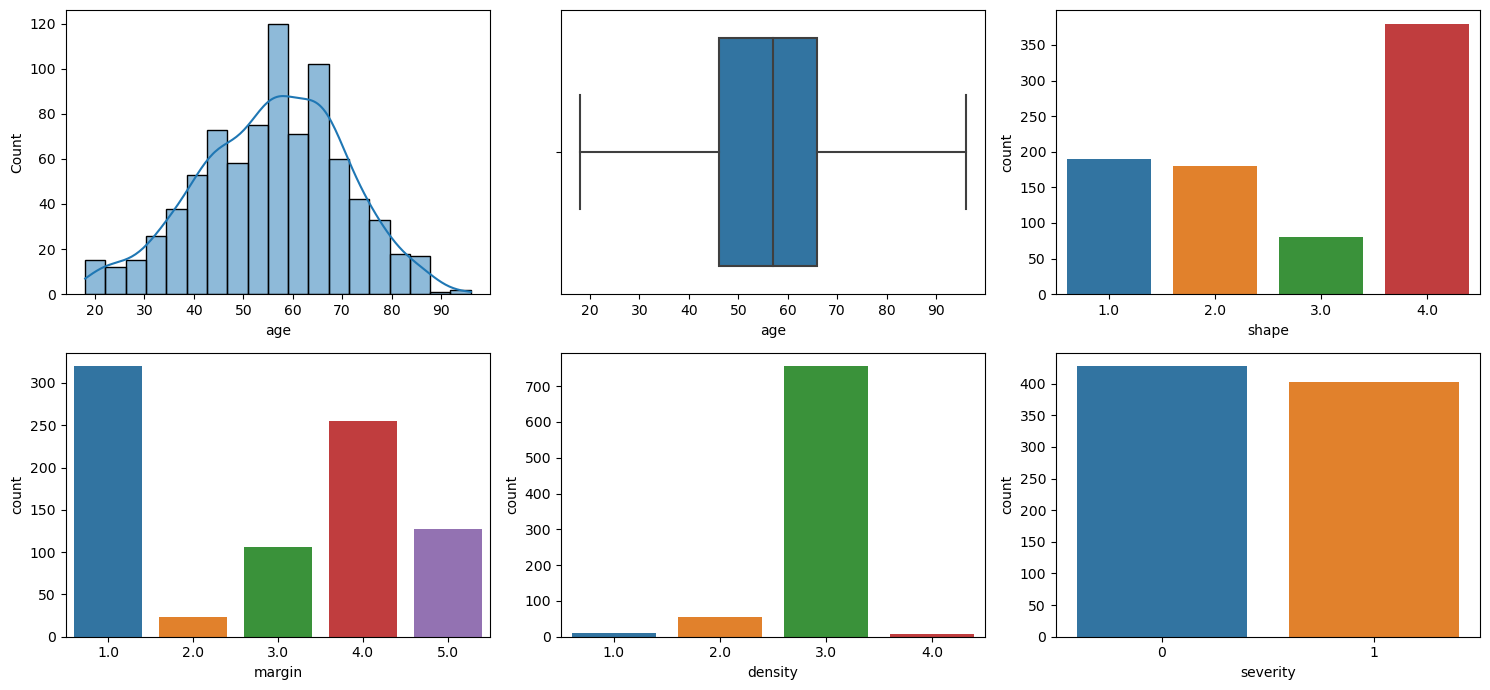

In [24]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
sns.histplot(masses_data['age'], kde=True)

plt.subplot(2, 3, 2)
sns.boxplot(x='age', data=masses_data)

plt.subplot(2, 3, 3)
sns.countplot(x='shape', data=masses_data)

plt.subplot(2, 3, 4)
sns.countplot(x='margin', data=masses_data)

plt.subplot(2, 3, 5)
sns.countplot(x='density', data=masses_data)

plt.subplot(2, 3, 6)
sns.countplot(x='severity', data=masses_data)

plt.tight_layout()

plt.show()

### 1.4 Multivariate Analysis

#### 1.4.1 Correlation 
Shape and margin have the highest correlation (0.74) and they are also the ones with the highest correlation with the target variable, followed by age. This suggests they will have an import role in predicting whether the mass is malignant or benign.

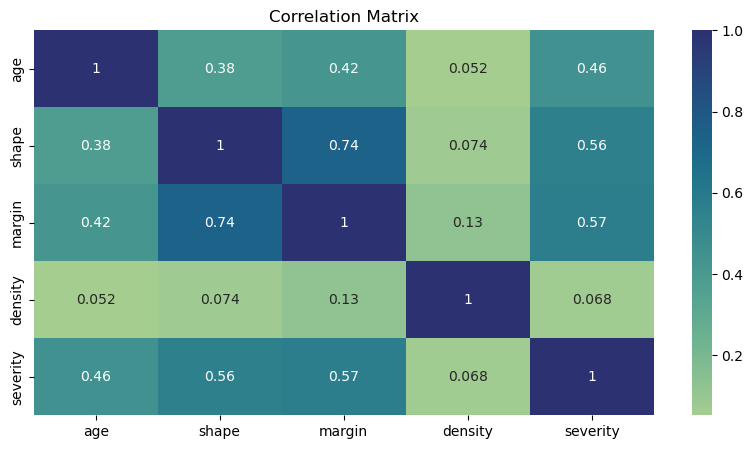

In [25]:
plt.figure(figsize=(10,5))
c= masses_data.corr()
sns.heatmap(c,cmap="crest",annot=True)
plt.title("Correlation Matrix")
plt.show()

#### 1.4.2 Relationship with the Target Variable

A discernible trend is that individuals with malignant masses tend to be older. Moreover, when examining the features of `shape` and `margin`, we find that benign masses are often characterized by lower values, while malignant masses typically exhibit higher values. This implies that elevated values in these features could be potent indicators of malignancy. Conversely, the `density` feature appears to have a negligible influence on the severity prediction, given the consistent outcomes across its different values.

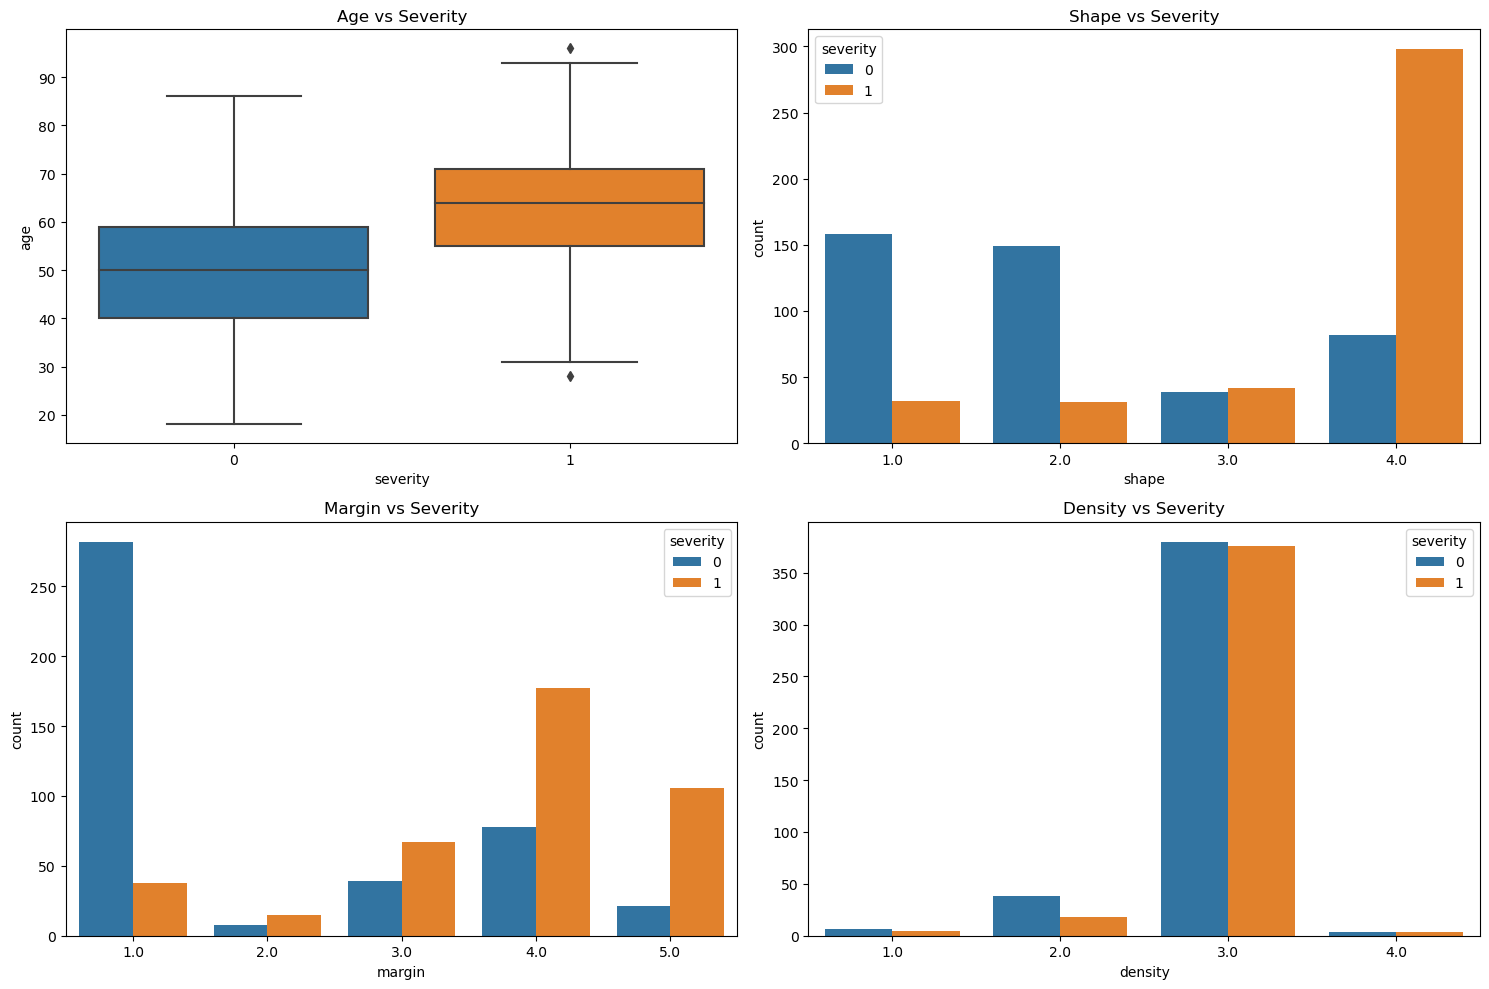

In [26]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=masses_data, x="severity", y="age")
plt.title("Age vs Severity")

plt.subplot(2, 2, 2)
sns.countplot(data=masses_data, x="shape", hue="severity")
plt.title("Shape vs Severity")

plt.subplot(2, 2, 3)
sns.countplot(data=masses_data, x="margin", hue="severity")
plt.title("Margin vs Severity")

plt.subplot(2, 2, 4)
sns.countplot(data=masses_data, x="density", hue="severity")
plt.title("Density vs Severity")

plt.tight_layout()

plt.show()

### 1.5 Conclusions
- 130 rows were removed due to missing values
- The `BI-RADS` column was removed
- No outliers
- `shape`, `margin` and `age` look like the most relevant predictors of severity
- 831 instances, 4 features, 1 target. 

In [27]:
masses_data

,age,shape,margin,density,severity
0,67.0,3.0,5.0,3.0,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
8,57.0,1.0,5.0,3.0,1
10,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
956,47.0,2.0,1.0,3.0,0
957,56.0,4.0,5.0,3.0,1
958,64.0,4.0,5.0,3.0,0
959,66.0,4.0,5.0,3.0,1


## 2. Pre-Processing
- many rows contain **missing data**
- erroneous data identifiable as outliers

#### Scaling/Normalization
Remember some techniques such as SVM also require the input data to be normalized first.

## 3. Apply ML methods

In [28]:
X = masses_data.drop('severity', axis=1)
y = masses_data['severity']

### 3.1 Decision Trees

#### 3.1.1 Split in train and test sets

In [29]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=3)

# Fit the classifier with training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [31]:
# Make predictions
y_pred = clf.predict(X_test)

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       133
           1       0.73      0.82      0.77       117

    accuracy                           0.77       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.78      0.77      0.77       250

[[97 36]
 [21 96]]


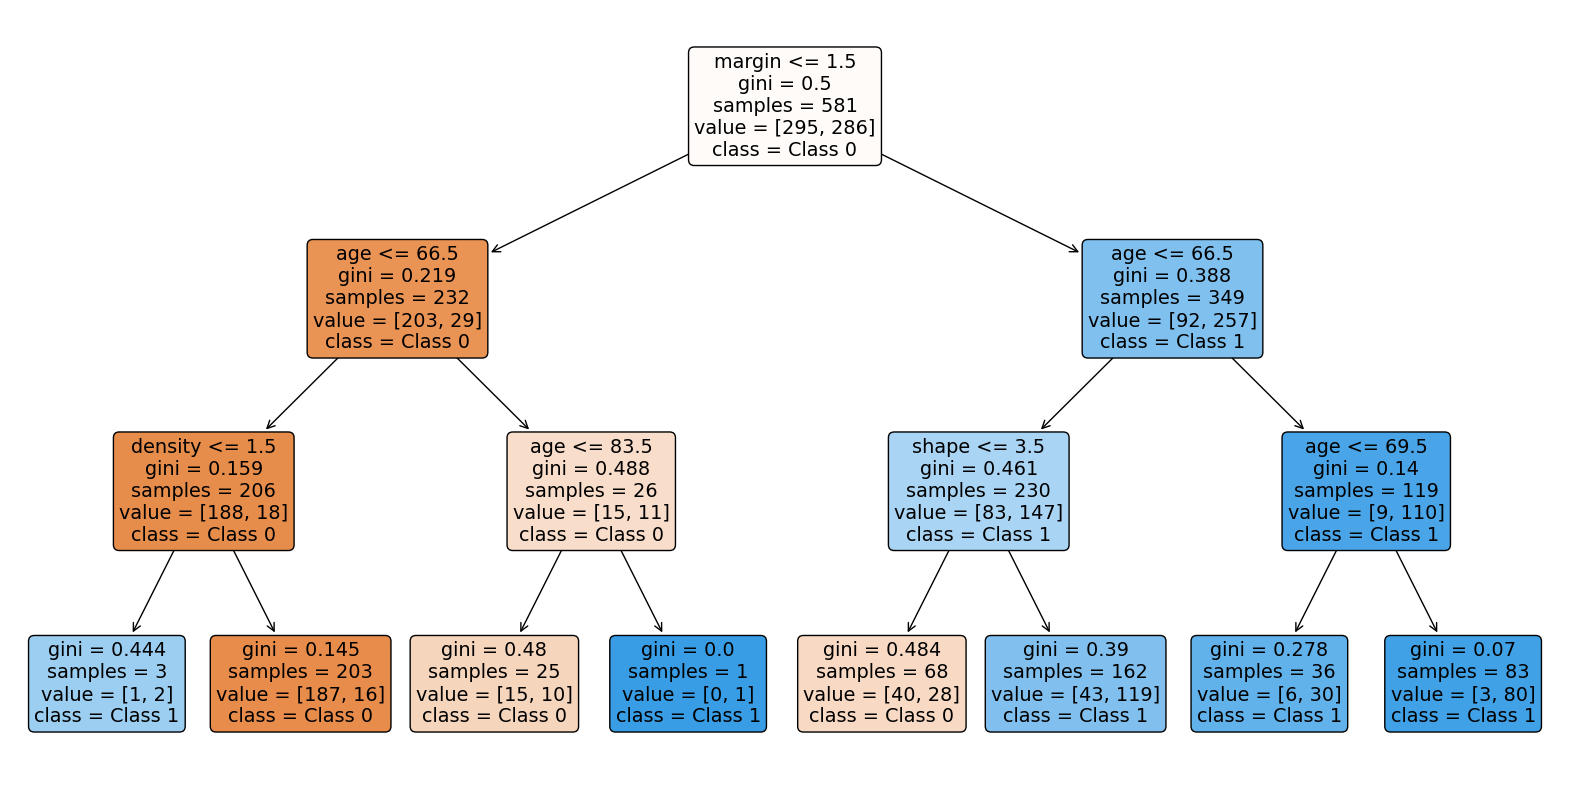

In [33]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns.tolist(), class_names=["Class 0", "Class 1"], rounded=True)
plt.show()

#### 3.1.2 Cross-validation

In [34]:
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=3)

scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.07)


### 3.2 Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=8)
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.75 (+/- 0.10)


#### 3.2.2. XGBoost

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 3} 
epochs = 10 

model = xgb.train(param, train, epochs)
predictions = model.predict(test)

accuracy_score(y_test, predictions)

0.8

In [37]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
scores = cross_val_score(xgb_classifier, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.78 (+/- 0.07)


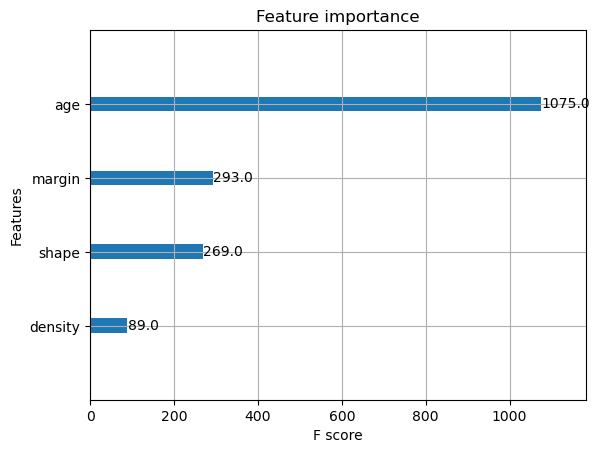

In [38]:
# Fit the model to the entire dataset
xgb_classifier.fit(X, y)

# Plot feature importances
xgb.plot_importance(xgb_classifier)
plt.show()

### 3.3 kNN

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 3.3.x Parameter Tuning

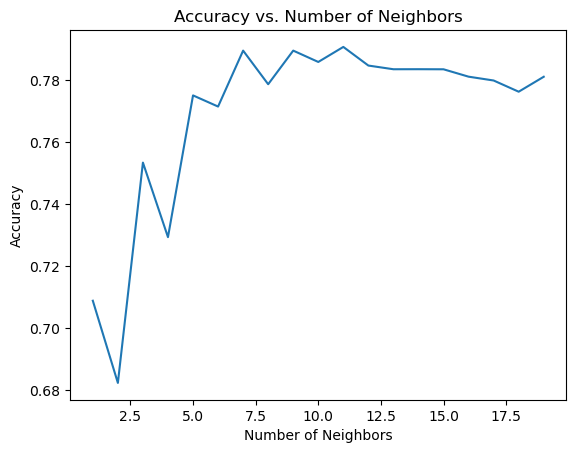

In [40]:
neighbors_range = list(range(1,20))
cv_scores = []

for n in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_scaled, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Visualizing the CV scores
plt.plot(neighbors_range, cv_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.show()

### 3.4 Naive Bayes

In [41]:
nb_clf = GaussianNB()
scores = cross_val_score(nb_clf, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.09)


### 3.5 Support Vector Machines (SVM)

In [42]:
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['auto', 'scale', 0.1, 1, 10, 100]
}

pipeline = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Cross-Validation Score: 0.8075174951302216


### 3.6 Logistic Regression

In [43]:
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']  # these solvers are compatible with both L1 and L2 penalty
}

pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))  # Increased max_iter for convergence

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best Cross-Validation Score: 0.8038958228122068


### 3.7 Neural Networks

#### 3.7.1 Scikit-learn

In [ ]:
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlpclassifier__activation': ['logistic', 'relu', 'tanh'],
    'mlpclassifier__solver': ['sgd', 'adam'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'mlpclassifier__learning_rate': ['constant', 'adaptive']
}

pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, random_state=42))

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/d

/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/diogoramalho/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/d

#### 3.7.2 Tensorflow